In [2]:
!pip install music21

In [1]:
from music21 import *
from matplotlib import pyplot as plt
from sklearn import svm, tree, naive_bayes, neighbors
import numpy as np
import graphviz
import data_loader as loader

In [7]:
%%capture
composerNames = ["mozart","haydn","tchaikovsky"]
count = min(loader.get_data_counts(composerNames))
x_train, x_test,y_train, y_test = loader.load("st",composerNames)


In [8]:
len(y_train)

709

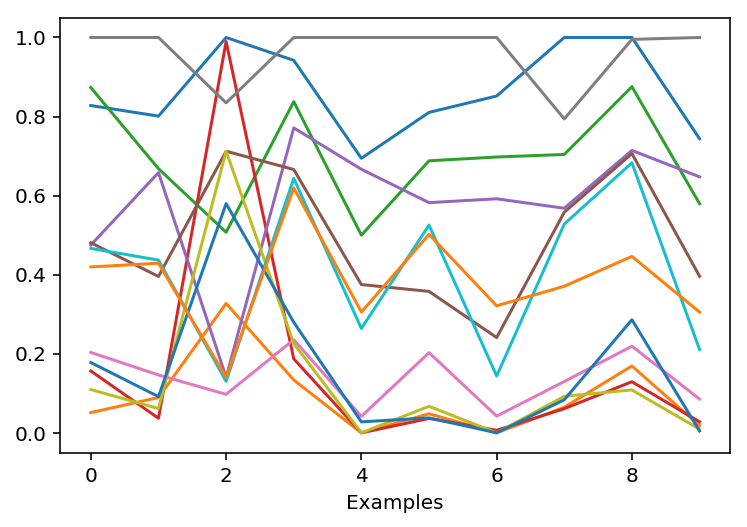

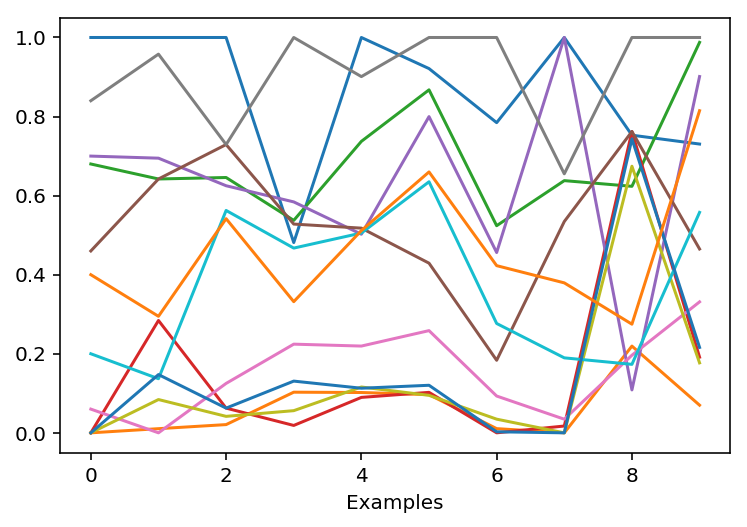

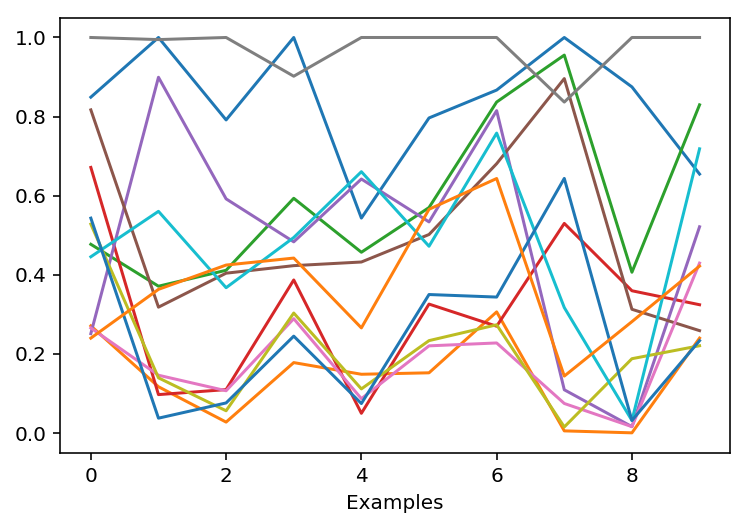

In [9]:
classes = list(set(y_test))
test_data = list(zip(x_test,y_test))
for label in classes:
    label_data = [tupple[0] for tupple in test_data if tupple[1] == label][:10]
    plt.plot(label_data)
    plt.xlabel("Examples")
    plt.show()

In [10]:
classifiers = [svm.SVC(kernel="linear"), 
               tree.DecisionTreeClassifier(), 
               neighbors.KNeighborsClassifier(n_neighbors=1),
               naive_bayes.MultinomialNB()]

for clf in classifiers:
    clf.fit(x_train,y_train)
    print(clf)
    print(f"acc: {clf.score(x_test,y_test)}","\n")

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
acc: 0.5869565217391305 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
acc: 0.5760869565217391 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
acc: 0.6340579710144928 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
acc: 0.4963768115942029 



In [11]:
for i in range(1,60):
    k_nn = neighbors.KNeighborsClassifier(n_neighbors=i)
    k_nn.fit(x_train, y_train)
    print(f"k = {i}, acc = {k_nn.score(x_test,y_test)}")

k = 1, acc = 0.6340579710144928
k = 2, acc = 0.5688405797101449
k = 3, acc = 0.6340579710144928
k = 4, acc = 0.5905797101449275
k = 5, acc = 0.6159420289855072
k = 6, acc = 0.6123188405797102
k = 7, acc = 0.6086956521739131
k = 8, acc = 0.5942028985507246
k = 9, acc = 0.605072463768116
k = 10, acc = 0.6014492753623188
k = 11, acc = 0.6159420289855072
k = 12, acc = 0.6014492753623188
k = 13, acc = 0.5978260869565217
k = 14, acc = 0.5797101449275363
k = 15, acc = 0.5869565217391305
k = 16, acc = 0.572463768115942
k = 17, acc = 0.5833333333333334
k = 18, acc = 0.5579710144927537
k = 19, acc = 0.5615942028985508
k = 20, acc = 0.5869565217391305
k = 21, acc = 0.5905797101449275
k = 22, acc = 0.5905797101449275
k = 23, acc = 0.5942028985507246
k = 24, acc = 0.605072463768116
k = 25, acc = 0.605072463768116
k = 26, acc = 0.6086956521739131
k = 27, acc = 0.6014492753623188
k = 28, acc = 0.605072463768116
k = 29, acc = 0.5869565217391305
k = 30, acc = 0.6159420289855072
k = 31, acc = 0.58333333